<img src="https://i.imgur.com/vnejHGh.png" width="800">
<!--- @wandbcode{huggingface_optimize_wandb} -->

<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/huggingface/Optimize_Hugging_Face_models_with_Weights_%26_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimize 🤗 Hugging Face models with Weights & Biases

[Hugging Face](https://huggingface.co/) provides tools to quickly train neural networks for NLP (Natural Language Processing) on any task (classification, translation, question answering, etc) and any dataset with PyTorch and TensorFlow 2.0.

Coupled with [Weights & Biases integration](https://docs.wandb.ai/integrations/huggingface), you can quickly train and monitor models for full traceability and reproducibility without any extra line of code! You just need to install the library, sign in, and your experiments will automatically be logged:

```bash
pip install wandb
wandb login
```

**Note**: To enable logging to W&B, set `report_to` to `wandb` in your `TrainingArguments` or script.

W&B integration with 🤗 Hugging Face can automatically:
* log your configuration parameters
* log your losses and metrics
* log gradients and parameter distributions
* log your model
* keep track of your code
* log your system metrics (GPU, CPU, memory, temperature, etc)

## 🛠️ Installation and set-up

We need the following 🤗 Hugging Face libraries:
* [transformers](https://huggingface.co/transformers/) contains an API for training models and many pre-trained models
* [tokenizers](https://huggingface.co/docs/tokenizers/python/latest/) is automatically installed by transformers and "tokenize" our data (ie it converts text to sequence of numbers)
* [datasets](https://huggingface.co/docs/datasets/) contains a rich source of data and common metrics, perfect for prototyping

We also install `wandb` to automatically instrument our training.

In [ ]:
!pip install -qqq transformers datasets wandb

In [ ]:
# Optional -> install latest version from source
!pip install -qqq git+https://github.com/huggingface/transformers

We finally make sure we're logged into W&B so that our experiments can be associated to our account.

In [3]:
import wandb
wandb.login()

## 💡 Configuration tips

W&B integration with Hugging Face can be configured to add extra functionalities:

* auto-logging of models as artifacts: just set environment varilable `WANDB_LOG_MODEL` to `true`
* log histograms of gradients and parameters: by default gradients are logged, you can also log parameters by setting environment variable `WANDB_WATCH` to `all`
* set custom run names with `run_name` arg present in scripts or as part of `TrainingArguments`
* organize runs by project with the `WANDB_PROJECT` environment variable

For more details refer to [W&B + HF integration documentation](https://docs.wandb.ai/integrations/huggingface).

Let's log every trained model.

In [4]:
%env WANDB_LOG_MODEL=true

env: WANDB_LOG_MODEL=true


## 🚅 Training a new model the quick way!

When working on a new problem, you should always check [the summary of task](https://huggingface.co/transformers/task_summary.html) as there will often be a script that can already solve your task. At a minimum they will be a great source of inspiration for your own custom pipeline.

Let's use the Hugging Face script responsible for training on any GLUE task, such as sequence classification.

In [5]:
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/text-classification/run_glue.py -qq

These scripts are automatically instrumented when `wandb` is installed and logged in.

**Note:** set `report_to` to `wandb` to enable logging through W&B.

In [ ]:
!python run_glue.py \
  --report_to wandb \
  --model_name_or_path bert-base-uncased \
  --task_name MRPC \
  --learning_rate 1e-4 \
  --do_train \
  --do_eval \
  --max_steps 300 \
  --logging_steps 30 \
  --evaluation_strategy steps \
  --output_dir /tmp/MRPC \
  --overwrite_output_dir \
  --run_name demo

You just trained a model and can now visualize your metrics in your dashboard!

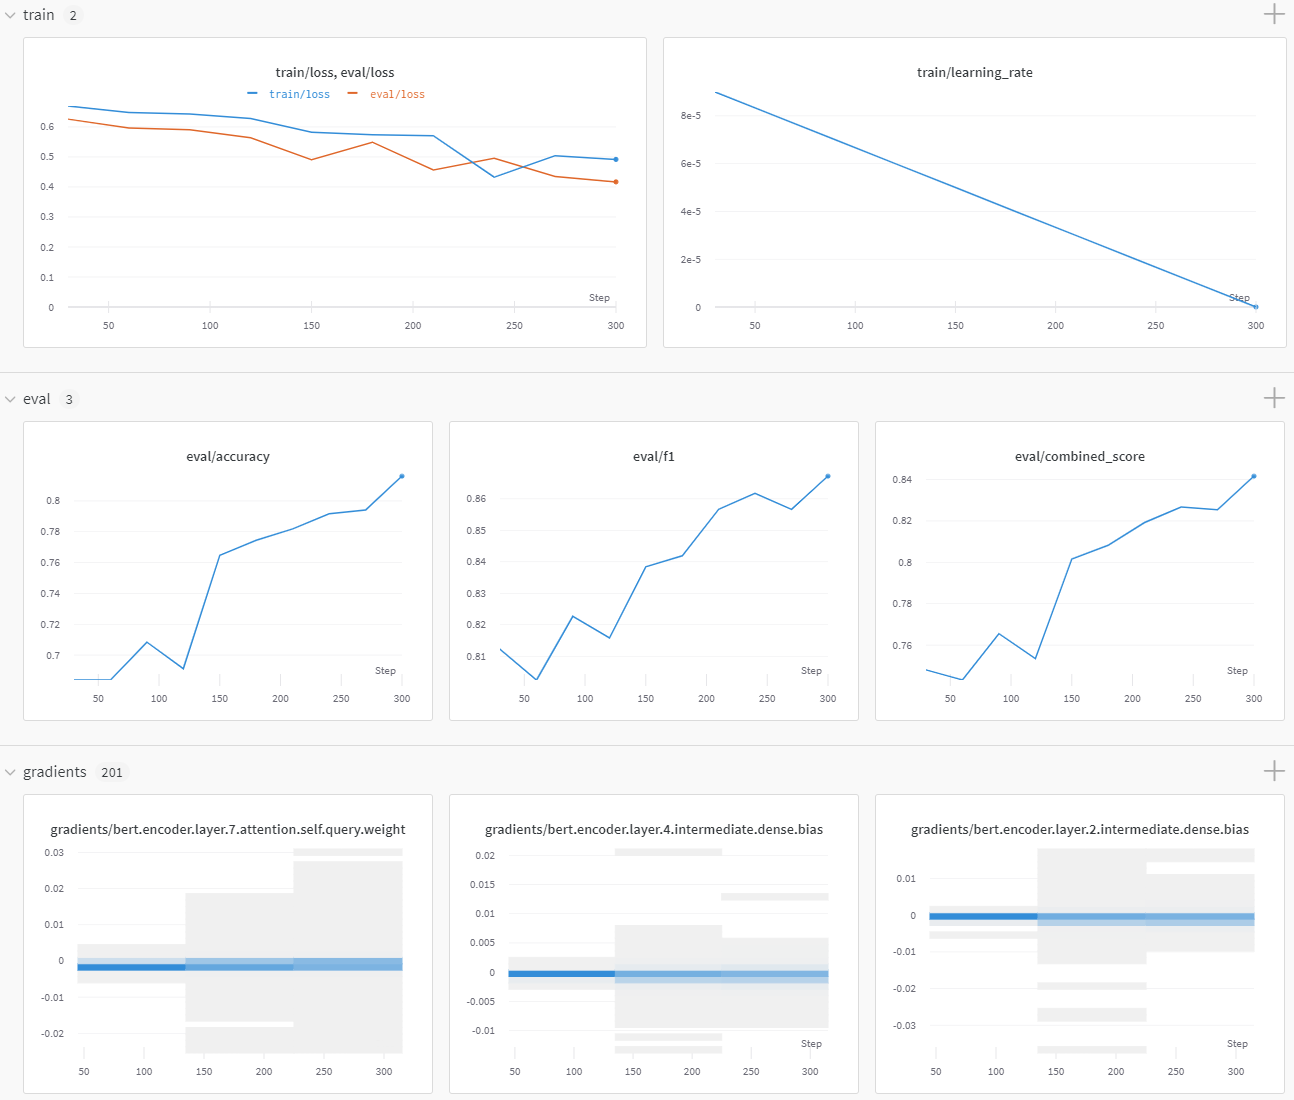


In addition, your model files have been saved and versioned, along with associated metadata (evaluation & training metrics).

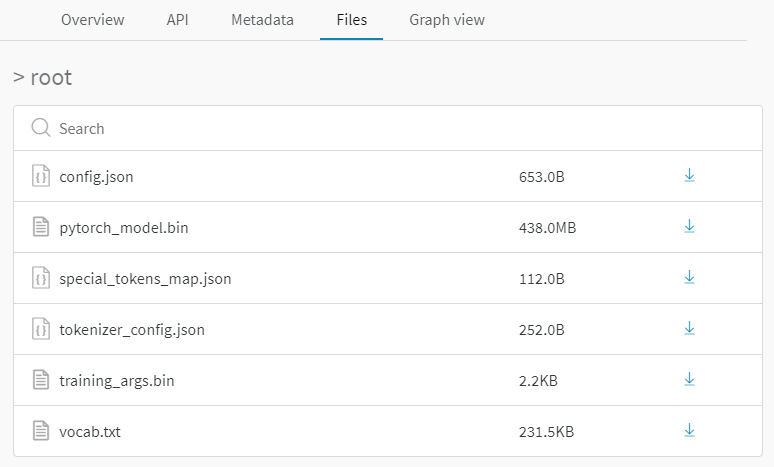



# 🔬 Advanced usage & custom training

Let's create our own logic for a more customized training.

### ✏️ Preparing a dataset

The dataset will vary based on the task you work on. Let's work on sequence classification!

Our dataset will be composed of sentences and their associated classes. For example if you wanted to identify the subject of a conversation, you could create a dataset such as:

input | class
--- | ---
The team scored a goal in the last seconds | sports
The debate was heated between the 2 parties | politics
I've never tasted croissants so delicious ! | food

The objective of our trained model will be to correctly identify the class associated to new sentences.

### 🔎 Finding a dataset

If you don't have the right dataset, you can always explore the [Datasets Hub](https://huggingface.co/datasets). The ["topic classification" category](https://huggingface.co/datasets?filter=task_ids:topic-classification) contains many datasets suitable for prototyping this model.

We select ["Yahoo! Answers Topic Classification"](https://huggingface.co/datasets/yahoo_answers_topics) and visualize it with the [Datasets viewer](https://huggingface.co/datasets/viewer/?dataset=yahoo_answers_topics).

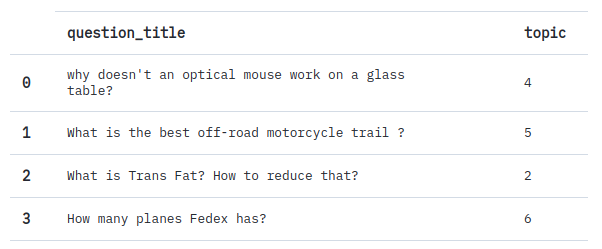

Each topic number reprersent a unique subject:

* 0:"Society & Culture"
* 1:"Science & Mathematics"
* 2:"Health"
* etc…

They correspond to the output we will try to predict from the model.

### 🏷️ Loading a dataset

Any dataset from the Datasets Hub can easily be loaded and is automatically downloaded if not present locally.

In [7]:
from datasets import load_dataset
dataset = load_dataset("yahoo_answers_topics")

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/a1bc78ef81f1057593777a45c199fada1fd6decb8a3d9f5aea63b47dc884b0dd. Subsequent calls will reuse this data.


Just printing our dataset object gives us a lot of information.

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 60000
    })
})

We can easily access any element.

In [9]:
dataset['train'][0]

{'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.',
 'id': 0,
 'question_content': 'or even on some surfaces?',
 'question_title': "why doesn't an optical mouse work on a glass table?",
 'topic': 4}

`str2int` and `int2str` help us go from class label to their integer mapping.

In [10]:
dataset['train'].features['topic'].int2str(4)

'Computers & Internet'

For our topic classification task, we use `question_title` as input and try to predict `topic`.

In [11]:
label_list = dataset['train'].unique('topic')
label_list.sort()
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

This particular dataset is split between 10 different topics, that will be represented by 10 classes from our model output.

In [12]:
num_labels = len(label_list)
num_labels

10

The "topic" class needs to be renamed to "labels" for the `Trainer` to find it.

In [13]:
dataset.rename_column_('topic', 'labels')

### ⚙️ Tokenizing the dataset

In order to train a neural network, we need to convert our inputs to numbers:
* the tokenizer divides a sequence of characters into tokens, ie sub-sequences (such as words, characters, sub-words…)
* each unique token is mapped to a unique integer

There are many [types of tokenizers](https://huggingface.co/transformers/tokenizer_summary.html). 🤗 Transformers can auto-select the right `Tokenizer` associated to a specific model.

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

The tokenizer let us quickly preprocess our data.

In [15]:
sample_input = dataset['train'][0]['question_title']
sample_input

"why doesn't an optical mouse work on a glass table?"

In [16]:
tokenizer(sample_input)

{'input_ids': [101, 2339, 2987, 1005, 1056, 2019, 9380, 8000, 2147, 2006, 1037, 3221, 2795, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

The tokenizer can quickly process an entire dataset and cache the results locally to avoid any future tokenization of the same data.

We leverage `dataset.map(fn)` function which can efficiently apply any function to a dataset. We also take advantage of batch processing which is supported by the tokenizer and makes the operation even faster.

In [17]:
dataset = dataset.map(lambda x: tokenizer(x['question_title'], truncation=True), batched=True)

We truncate the data to the max length supported by the model. During training, we will pass the tokenizer to pad inputs to the longest sequence of the batch (the model requires same length inputs in a single batch).

Our dataset now contains new keys: `input_ids` (tokens) and `attention_mask` (needed for certain models).

In [18]:
dataset['train'][0]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.',
 'id': 0,
 'input_ids': [101,
  2339,
  2987,
  1005,
  1056,
  2019,
  9380,
  8000,
  2147

### ✨ Loading a model

Plenty of models are available and can be explored on the [Model Hub](https://huggingface.co/models).

Once a model has been selected, it can be automatically loaded and adapted to one of its supported tasks.

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

In this case, we are loading a pre-trained network to which a custom head has been added for sequence classification and presents 10 classes corresponding to the possible topics of this dataset.

Let's make a function to return the topic prediction from a sample question.

In [20]:
import torch

def get_topic(sentence, tokenize=tokenizer, model=model):
    # tokenize the input
    inputs = tokenizer(sentence, return_tensors='pt')
    # ensure model and inputs are on the same device (GPU)
    inputs = {name: tensor.cuda() for name, tensor in inputs.items()}
    model = model.cuda()
    # get prediction - 10 classes "probabilities" (not really true because they still need to be normalized)
    with torch.no_grad():
        predictions = model(**inputs)[0].cpu().numpy()
    # get the top prediction class and convert it to its associated label
    top_prediction = predictions.argmax().item()
    return dataset['train'].features['labels'].int2str(top_prediction)

Let's test a prediction on a sample sentence.

In [21]:
get_topic('Why is cheese so much better with wine?')

'Science & Mathematics'

Obviously the model has not been trained yet so the results are still random.

### 🎉 Training the model

We now need to fine-tune the model based on our dataset.

The `Trainer` class let us easily train a model and is very flexible.

**Note:** set `report_to` to `wandb` in `TrainingArguments` to enable logging through W&B.

In [22]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    report_to = 'wandb',                     # enable logging to W&B
    output_dir = 'topic_classification',    # output directory
    overwrite_output_dir = True,
    evaluation_strategy = 'steps',          # check evaluation metrics at each epoch
    learning_rate = 5e-5,                   # we can customize learning rate
    max_steps = 30000,
    logging_steps = 100,                    # we will log every 100 steps
    eval_steps = 5000,                      # we will perform evaluation every 500 steps
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    run_name = 'custom_training'            # name of the W&B run
)

For more customization, refer to [`TrainingArguments` documentation](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments).

We can optionally define metrics to calculate in addition to the loss through the `compute_metrics` function.

Several [metrics](https://huggingface.co/metrics) are readily available from the datasets library to monitor model performance.

In [23]:
from datasets import load_metric
import numpy as np

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    # metrics from the datasets library have a `compute` method
    return accuracy_metric.compute(predictions=predictions, references=labels)

The `Trainer` handles all the training & evaluation logic.

In [24]:
trainer = Trainer(
    model = model,                  # model to be trained
    args = args,                    # training args
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,            # for padding batched data
    compute_metrics=compute_metrics # for custom metrics
)

We can verify that we initially have an accuracy of about 10% (random predictions over 10 classes).

In [25]:
trainer.evaluate()

wandb: Currently logged in as: borisd13 (use `wandb login --relogin` to force relogin)


{'eval_accuracy': 0.09091666666666667,
 'eval_loss': 2.3021934032440186,
 'eval_runtime': 65.8421,
 'eval_samples_per_second': 911.271}

We start training by simply calling `train()`.

In [26]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
5000,1.049900,1.083768,0.671300,92.011000,652.096000
10000,1.017000,1.013471,0.685467,66.556800,901.486000
15000,1.030200,0.972054,0.693467,66.247100,905.700000
20000,0.959600,0.947843,0.700733,66.361000,904.146000
25000,0.911400,0.925875,0.709117,66.494000,902.337000
30000,0.925700,0.911730,0.712600,66.514300,902.061000


TrainOutput(global_step=30000, training_loss=1.0100374313354492, metrics={'train_runtime': 1912.3902, 'train_samples_per_second': 15.687, 'total_flos': 2588044625785632, 'epoch': 0.17})

We can monitor losses, metrics, gradients and parameters as the model trains.

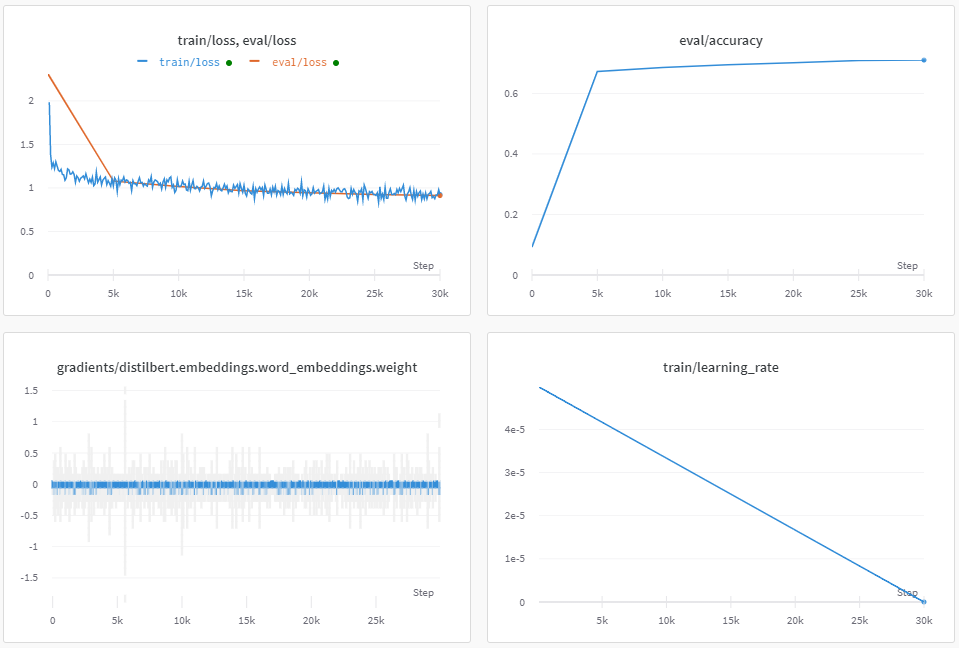

When training is complete, our model is logged and versioned along with its performance as metadata.

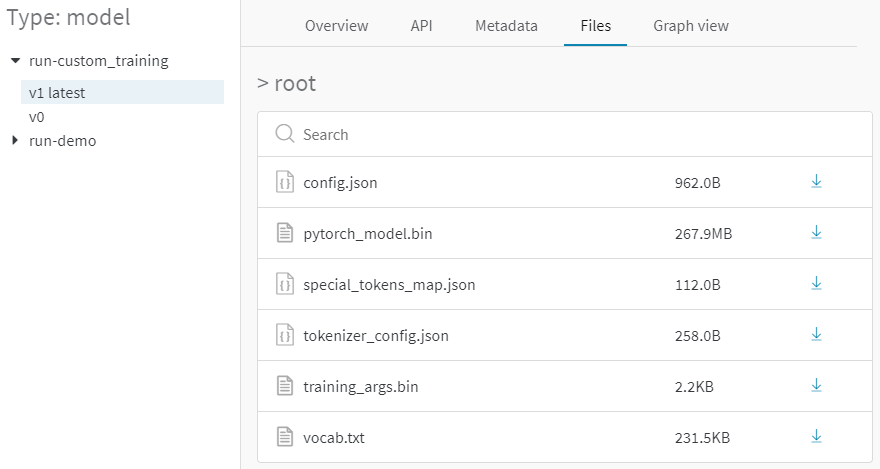

We can now use the trained model for better predictions.

In [27]:
get_topic('Why is cheese so much better with wine?')

'Health'

When we want to close our W&B run, we can call `wandb.finish()` (mainly useful in notebooks, called automatically in scripts).

In [2]:
wandb.finish()

Once you're happy with a model, don't forget to [share it with the word](https://huggingface.co/transformers/model_sharing.html) on the Model Hub!

## 📚 Resources

* [Hugging Face and W&B integration documentation](https://docs.wandb.ai/integrations/huggingface) contains a few tips for taking most advantage of W&B
* [🤗 Transformers documentation](https://huggingface.co/transformers/) is extremely thorough and full of examples

## ❓ Questions about W&B

If you have any questions about using W&B to track your model performance and predictions, please reach out to the [slack community](http://bit.ly/wandb-forum).